In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook")
#sns.set_context("poster")


In [2]:
# For this exercise you need to install yellowbrick
# it will be also useful to take a look at the documentation
#    scikit-yb.org
#
# ! pip install yellowbrick

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn import preprocessing

from sklearn.datasets import load_wine
from sklearn.datasets import load_boston

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.model_selection import LearningCurve


<h1>Clustering</h1>

Clustering is the most common and well-known unsupervised learning techniques. We can find clustring almost everywhere, in political campaigns, in client segmentation, ... The aglomeration of similar items is very familiar to us, Cities are clusters of people and in cities business traditionally cluster.

However, the fact that clustering is unsupervised poses some problems to validation metrics and verification. There is normally no grown truth, therefore there is not a single solution. Many times clusters, including its number, depends on the point of view of the problem and the questions that we are trying to address. 

The first problem that we encounter with clustering is finding out the best number of clusters. For this the elbow method is commonly used. It performs k-means with an increasingly number of clusters finding the k (number of clusters) that minimizes intra-cluster distance.

Checking the goodness is commonly done using the Silhoutte coefficient that measures the mean intra-cluster distance relative to the nearest clusters providing an appreciation of compactness. 

Clustering is very intuitive in two-dimensional spaces, but difficult to imagine in multidimensional spaces. The output of a clustering algorithm are centroids which consists of vectors with the center for each attribute. Using predict we can easily assign membership. 

Also we aware that clustering works measuring distances, therefore we need to rescaled (normally between 0..1) all the attributes. 

In this notebook we will use the UCI wine dataset, a compilation of characteristics of 178 Italian red wines divided in three families. We will see how well clustering can find without any example these three classes. 

In many cases, like this one, clustering has some coincidences with classification. This is precisely this case. When this happens we know the ground truth and therefore we can apply measures such as accuracy. However, this is uncommon, and therefore assessing its goodness is difficult. 

This notebook heavily uses the yellowbrick library, please install it with 
<p style="margin-left: 200px"> <b><i>pip install yellowbrick</i></b> </p>

<img src="wine-dataset.jpg">

In [3]:
# We use the wine dataset
wine = load_wine()

print(wine["DESCR"])

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,TARGET
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


{'data': array([[1.423e+01, 1.710e+00, 2.430e+00, ..., 1.040e+00, 3.920e+00,
         1.065e+03],
        [1.320e+01, 1.780e+00, 2.140e+00, ..., 1.050e+00, 3.400e+00,
         1.050e+03],
        [1.316e+01, 2.360e+00, 2.670e+00, ..., 1.030e+00, 3.170e+00,
         1.185e+03],
        ...,
        [1.327e+01, 4.280e+00, 2.260e+00, ..., 5.900e-01, 1.560e+00,
         8.350e+02],
        [1.317e+01, 2.590e+00, 2.370e+00, ..., 6.000e-01, 1.620e+00,
         8.400e+02],
        [1.413e+01, 4.100e+00, 2.740e+00, ..., 6.100e-01, 1.600e+00,
         5.600e+02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,TARGET
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


,alcohol
TARGET,
0,59
1,71
2,48


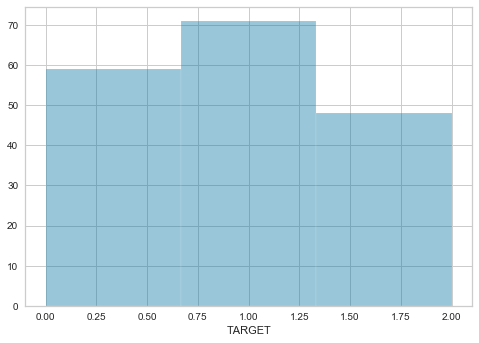

In [4]:
wine_df = pd.DataFrame(wine.data, columns=wine.feature_names)
wine_df['TARGET'] = wine.target
wine_df.head()
wine
wine_df.describe()

wine_df[["TARGET", "alcohol"]].groupby("TARGET").count()

sns.distplot(wine_df["TARGET"],bins=3, kde=False)


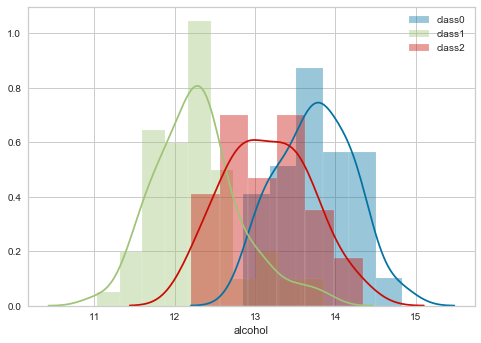

In [5]:
# let's plot the alcohol percentage for each class of wine

for i in wine_df["TARGET"].unique():
    sns.distplot(wine_df["alcohol"][wine_df["TARGET"]==i], label=f'class{i:d}')
plt.legend()


In [6]:
# Kmeans relies in a distance metric, therefore we need to rescale all features to the same scale 

X = wine_df.drop(['TARGET'], axis=1)
y = wine_df['TARGET']

min_max_scaler = preprocessing.MinMaxScaler()  # by default between 0 and 1

x_scaled_fit = min_max_scaler.fit(X)

x_scaled = min_max_scaler.fit_transform(X)
X_scaled = pd.DataFrame(x_scaled,columns=X.columns)
X_scaled.head()



,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963


<Figure size 864x648 with 0 Axes>

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001D5D50E5CF8>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

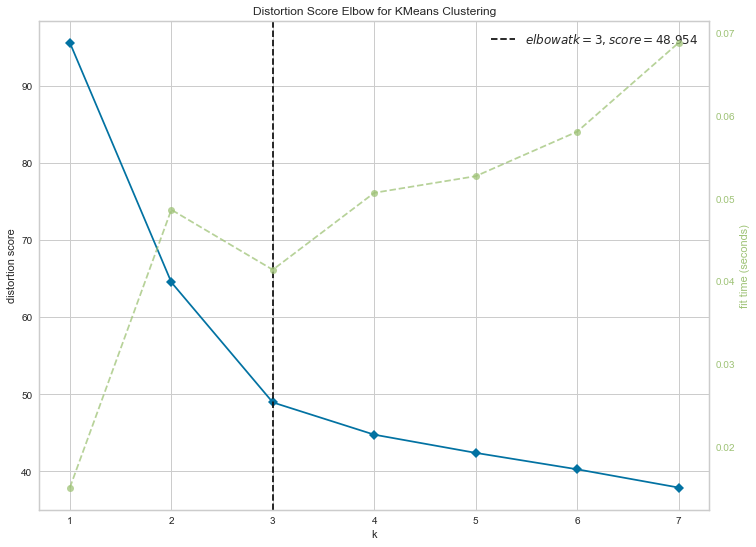

In [7]:
# Elbow method

plt.figure(figsize=(12,9))

# Now we apply KMeans
model = KMeans()

# we want first to find out how many clusters using the elbow technique
visualizer = KElbowVisualizer(model, k=(1,8))
visualizer.fit(X_scaled)       
visualizer.show()


# we know that there are 3 wine types (target=[0,1,2]) 
# and the elbow method correctely chooses 3

<Figure size 864x648 with 0 Axes>

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001D5D58C57B8>,
                     colors='yellowbrick', is_fitted='auto', model=None)

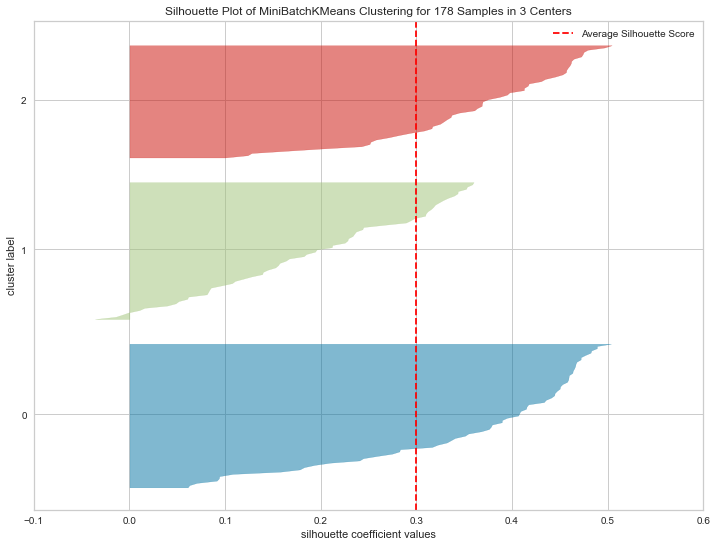

In [8]:
# Now we use Silhoutte to visualize the compactness of the clusters

plt.figure(figsize=(12,9))

#model = KMeans(3)
#model=MiniBatchKMeans(n_clusters=3, verbose=True).fit(X_scaled)

model=MiniBatchKMeans(n_clusters=3).fit(X_scaled)


visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_scaled)      
visualizer.show()


<Figure size 864x648 with 0 Axes>

InterclusterDistance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001D5D55D6198>,
                     embedding='mds', is_fitted='auto', legend=True,
                     legend_loc='lower left', legend_size=1.5, max_size=25000,
                     min_size=10000, model=None, random_state=None,
                     scoring='membership')

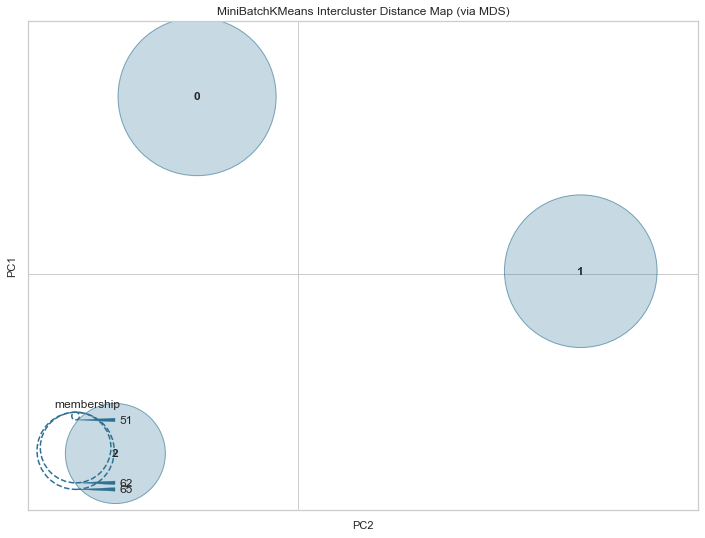

In [9]:
# Inter cluster distance 

plt.figure(figsize=(12,9))

#model=MiniBatchKMeans(n_clusters=3).fit(X_scaled)

visualizer = InterclusterDistance(model, min_size=10000)
#visualizer = InterclusterDistance(model)
visualizer.fit(X_scaled)
visualizer.show()


<Figure size 864x648 with 0 Axes>

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LearningCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001D5D6C4C518>,
              cv=None, exploit_incremental_learning=False, groups=None,
              model=None, n_jobs=1, pre_dispatch='all', random_state=None,
              scoring='adjusted_rand_score', shuffle=False,
              train_sizes=array([0.1  , 0.325, 0.55 , 0.775, 1.   ]))

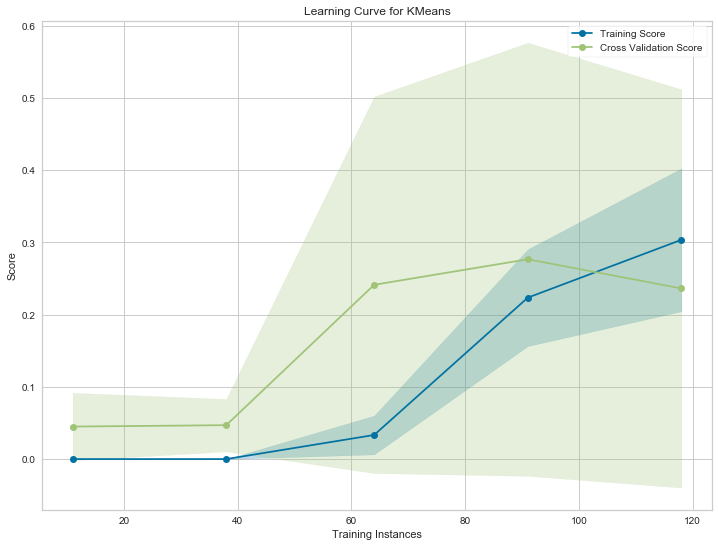

In [10]:
# Learning Curve
                            #this is used in deep learning not clustering!!!
plt.figure(figsize=(12,9))

model = KMeans()

visualizer = LearningCurve(model, scoring="adjusted_rand_score")

visualizer.fit(X_scaled, y)        # Fit the data to the visualizer
visualizer.show()                  # Finalize and render the figure

In [11]:
# Can we calculate accuracy ???
                                          #center of a cluster!! chi bel credit card l bi koun bel nos!!
#model=KMeans(3)                          #hayde it's the thing we use most!!
model=MiniBatchKMeans(n_clusters=3)

model.fit(X_scaled)

print("Predicted labels ----")
print(model.predict(X_scaled))
print()
print("Actual    labels ----")
print(y.values)
print()

print(" ---- Watch the labels ----")

acc_score=accuracy_score(y.values,model.predict(X_scaled))
print(f'Accuracy {acc_score*100:.3f}')


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=3, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

Predicted labels ----
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 2 0 0 0 0 0 0 2 0 2 0 0 1
 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]

Actual    labels ----
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]

 ---- Watch the labels ----
Accuracy 28.090


<h3>Silhouette score</h3>

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). 

The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. 

If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.
<p style="margin-left:200px"><b>
    a : mean distance between a sample and all other points in the same class. <br>
    b : mean distance between a sample and all other points in the next nearest cluster.
</b></p>
<br>
<p><b>
$$\large{s=\frac{b-a}{max(a,b}}$$
</b></p>

In [12]:
# Silhouette score

from sklearn import metrics

she=metrics.silhouette_score(X_scaled, model.labels_, metric="euclidean")
print(f'Silhouette score {she:5f}')

Silhouette score 0.300894


In [13]:
# Centroids
#center of a cluster!! chi bel credit card l bi koun bel nos!!
                         #hayde it's the thing we use most!!
model.labels_
model.cluster_centers_

pd.DataFrame(model.cluster_centers_, columns=X.columns)

# BECAUSE WE SCALED WE HAVE TO BRING IT BACK TO THE ORIGINAL RANGES

pd.DataFrame(x_scaled_fit.inverse_transform(model.cluster_centers_),columns=X.columns)

# --- Now with these values we can have an interpretation of what each cluster means ---

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 0, 0, 0, 0,
       0, 0, 2, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

array([[0.31826942, 0.2212153 , 0.47244697, 0.49225846, 0.24096897,
        0.46287655, 0.38595831, 0.40878165, 0.40351577, 0.15185652,
        0.4829087 , 0.57564307, 0.15889807],
       [0.70595395, 0.24335886, 0.57398619, 0.3367268 , 0.40919384,
        0.63594109, 0.5521097 , 0.30157233, 0.47609096, 0.35150206,
        0.48043699, 0.68619505, 0.59613796],
       [0.54156178, 0.47078536, 0.55846315, 0.5382788 , 0.30715974,
        0.24182159, 0.10665933, 0.62973749, 0.22804142, 0.47791215,
        0.20273595, 0.15842491, 0.24876264]])

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,0.318269,0.221215,0.472447,0.492258,0.240969,0.462877,0.385958,0.408782,0.403516,0.151857,0.482909,0.575643,0.158898
1,0.705954,0.243359,0.573986,0.336727,0.409194,0.635941,0.552110,0.301572,0.476091,0.351502,0.480437,0.686195,0.596138
2,0.541562,0.470785,0.558463,0.538279,0.307160,0.241822,0.106659,0.629737,0.228041,0.477912,0.202736,0.158425,0.248763


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,12.239424,1.859349,2.243476,20.149814,92.169145,2.322342,2.169442,0.346654,1.689145,3.059758,1.073978,2.841506,500.775093
1,13.712625,1.971396,2.433354,17.132500,107.645833,2.824229,2.957000,0.289833,1.919208,5.399604,1.070937,3.143313,1113.785417
2,13.087935,3.122174,2.404326,21.042609,98.258696,1.681283,0.845565,0.463761,1.132891,6.881130,0.729365,1.702500,626.765217


<h1>Agglomerative Hierarchical Clustering</h1>

Agglomerative hierarchical clustering differs from k-means in a key way. 
Rather than choosing a number of clusters and starting out with random centroids, we instead begin 
with every point in our dataset as a “cluster.” Then we  nd the two closest points and combine them into a cluster. 
Then, we  nd the next closest points, and those become a cluster. 

We repeat the process until we only have one big giant cluster.

<img src="dendrogram.png">

In [14]:
#we look for the 2 points that are closer and we put them together..+ we repeat them again for all pts!! 
#here we use the distance algorihtm!! 

<Figure size 1224x648 with 0 Axes>

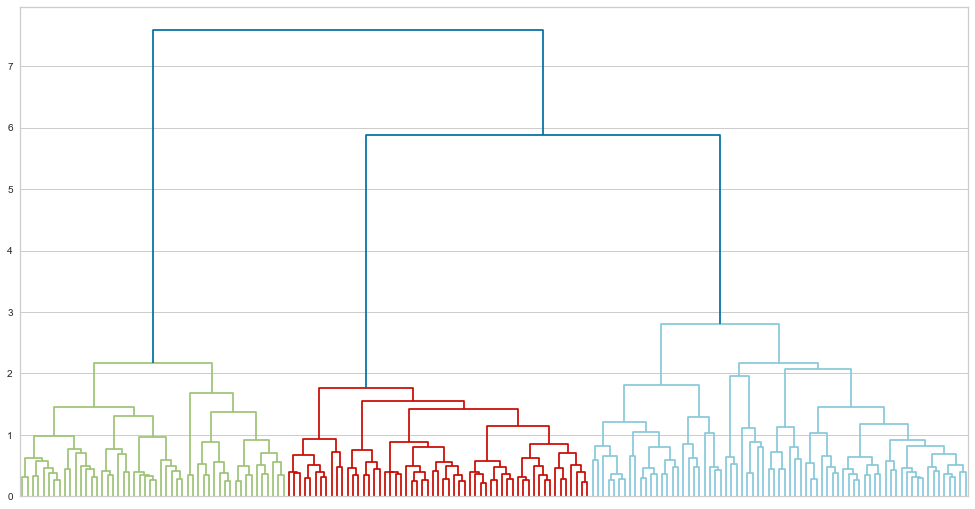

predictions --- 


array([2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

labels --- 


array([2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

pre-assigned labels --- 


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

Accuracy 97.753


In [15]:
 # import hierarchical clustering libraries           people don't use it that much because there's no centroid
import scipy.cluster.hierarchy as sch             #CHI SCIENCE LIBRARY NOT MACHINE LEARNING!!
from sklearn.cluster import AgglomerativeClustering     #for odd shapes we can use it!! 
          #sometimes we need to classify and not cluster!! 
plt.figure(figsize=(17,9))           #some clusters use distance! WE CAN PLAY WITH THE DISTANCE!! 

# create dendrogram
dn = sch.dendrogram(sch.linkage(X_scaled, method='ward'), no_labels=True)        
plt.show()

# create clusters
hc = AgglomerativeClustering(n_clusters=3, affinity = 'euclidean', linkage = 'ward')

# save clusters for chart y_hc = hc.fit_predict(points)
print("predictions --- ")
y_hc = hc.fit_predict(X_scaled)
y_hc

print("labels --- ")
hc.labels_

print("pre-assigned labels --- ")
y.values

dk={0:2,1:0,2:1}
acc_score=accuracy_score(list(map(lambda x:dk[x],y.values)),hc.labels_)
print(f'Accuracy {acc_score*100:.3f}')


In [16]:
#very accurate BUTTT bad news is that we don't have centroid!! 
#we have to build them!! take elements of cluster and find the mean of them so we find centroid!! 
#IT IS VERY CLEAR TO PRESENT!! AND IT WORKS BETTER!! 

<b><font color="red" size=6>Mission 1</font>

a) Cluster Europe using the EUindicators dataset and explain the clusterization using the centroids.<br><br>
b) Same for the credit card dataset. 
<br><br>
</b>

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 0 to 27
Data columns (total 7 columns):
 Country                                 26 non-null object
 Construction Confidence Indicator       26 non-null float64
 Consumer Confidence Indicator           26 non-null float64
 Industrial Confidence Indicator         26 non-null float64
 Retail Confidence Indicator             26 non-null float64
 Service Confidence Indicator            26 non-null float64
 Business Confidence Indicator (avg)     26 non-null float64
dtypes: float64(6), object(1)
memory usage: 1.6+ KB


,Country,Construction Confidence Indicator,Consumer Confidence Indicator,Industrial Confidence Indicator,Retail Confidence Indicator,Service Confidence Indicator,Business Confidence Indicator (avg)
0,Czech Republic,-19.7,3.5,3.1,19.8,33.1,9.075
1,Germany,-2.2,0.9,1.0,-3.7,18.5,3.400
2,Denmark,-4.3,15.0,-3.9,8.5,8.2,2.125
3,Finland,-4.0,14.9,-3.0,-4.7,11.0,-0.175
5,Malta,4.4,2.3,4.7,6.1,28.4,10.900


,Construction Confidence Indicator,Consumer Confidence Indicator,Industrial Confidence Indicator,Retail Confidence Indicator,Service Confidence Indicator,Business Confidence Indicator (avg)
0,0.418719,0.840056,0.810651,1.000000,1.000000,0.752277
1,0.706076,0.803894,0.686391,0.126394,0.569322,0.545537
2,0.671593,1.000000,0.396450,0.579926,0.265487,0.499089
3,0.676519,0.998609,0.449704,0.089219,0.348083,0.415301
4,0.814450,0.823366,0.905325,0.490706,0.861357,0.818761


<Figure size 864x648 with 0 Axes>

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001D5D709D7F0>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

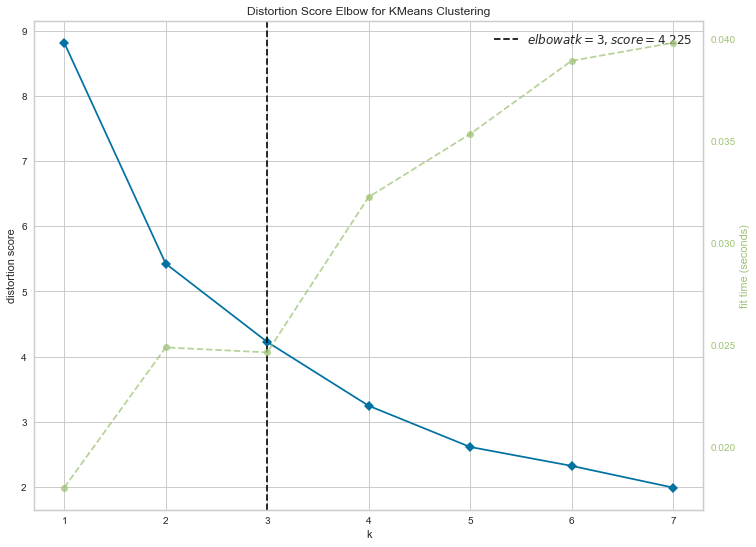

<Figure size 864x648 with 0 Axes>

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001D5D7220048>,
                     colors='yellowbrick', is_fitted='auto', model=None)

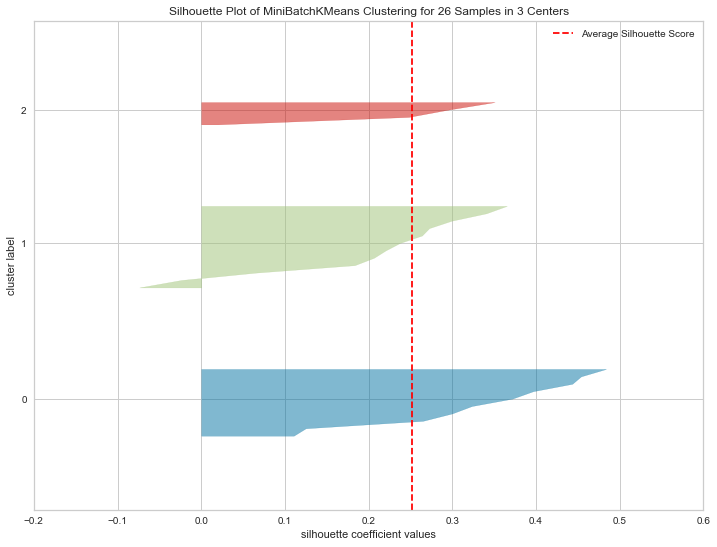

<Figure size 864x648 with 0 Axes>

InterclusterDistance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001D5D5861080>,
                     embedding='mds', is_fitted='auto', legend=True,
                     legend_loc='lower left', legend_size=1.5, max_size=25000,
                     min_size=10000, model=None, random_state=None,
                     scoring='membership')

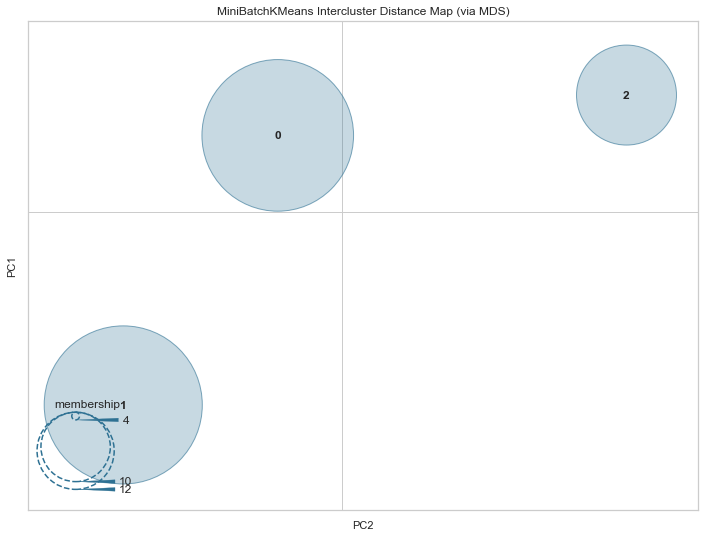

array([2, 1, 0, 1, 2, 0, 2, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 2, 0, 0])

array([[0.59133401, 0.68458467, 0.73989492, 0.65776503, 0.3133964 ,
        0.54129766],
       [0.42164894, 0.65954811, 0.41880806, 0.24830249, 0.30358517,
        0.2944185 ],
       [0.70732539, 0.81872765, 0.88997781, 0.82355284, 0.81753714,
        0.82499837]])

,Construction Confidence Indicator,Consumer Confidence Indicator,Industrial Confidence Indicator,Retail Confidence Indicator,Service Confidence Indicator,Business Confidence Indicator (avg)
0,0.591334,0.684585,0.739895,0.657765,0.313396,0.541298
1,0.421649,0.659548,0.418808,0.248302,0.303585,0.294418
2,0.707325,0.818728,0.889978,0.823553,0.817537,0.824998


,Construction Confidence Indicator,Consumer Confidence Indicator,Industrial Confidence Indicator,Retail Confidence Indicator,Service Confidence Indicator,Business Confidence Indicator (avg)
0,-9.187759,-7.678362,1.904224,10.593879,9.824138,3.283621
1,-19.521580,-9.478491,-3.522144,-0.420663,9.491537,-3.493212
2,-2.123884,1.966518,4.440625,15.053571,26.914509,11.071205


EXPLANATION:

I chose 3 clusters because the elbow test indicated that number. 3 clusters are enough to interpret this data
5 variables and the Buiness Confidence Indicator are present.
The first cluster (cluster 0) consists of the smaller (and negative) values, it consists of the countries
with the lower expected future development. The second cluster (cluster 1) consists of the countries that
are expected to develop the most (on the business side). The third cluster (cluster 2) consists of the
countries that have an average expected future business development.
This dataset can be used to determine the best location to invest in business in europe, it can be sold to invetors


In [17]:
# a)Cluster Europe using the EUindicators dataset and explain the clusterization using the centroids.
europe=pd.read_excel("EUIndicators-2014-2018.xlsx")
europe.dropna(inplace=True)
europe.info()
europe.head()
X=europe.iloc[:,1:]


min_max_scaler = preprocessing.MinMaxScaler()  # by default between 0 and 1

x_scaled_fit = min_max_scaler.fit(X)

x_scaled = min_max_scaler.fit_transform(X)
X_scaled = pd.DataFrame(x_scaled,columns=X.columns)
X_scaled.head()

plt.figure(figsize=(12,9))

# Now we apply KMeans
model = KMeans()

# we want first to find out how many clusters using the elbow technique
visualizer = KElbowVisualizer(model, k=(1,8))
visualizer.fit(X_scaled)       
visualizer.show()

plt.figure(figsize=(12,9))

# model = KMeans(3)
# model=MiniBatchKMeans(n_clusters=3, verbose=True).fit(X_scaled)

model=MiniBatchKMeans(n_clusters=3).fit(X_scaled)


visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_scaled)      
visualizer.show()

# Inter cluster distance 

plt.figure(figsize=(12,9))

#model=MiniBatchKMeans(n_clusters=3).fit(X_scaled)

visualizer = InterclusterDistance(model, min_size=10000)
#visualizer = InterclusterDistance(model)
visualizer.fit(X_scaled)
visualizer.show()


# Centroids
#center of a cluster!! chi bel credit card l bi koun bel nos!!
                         #hayde it's the thing we use most!!
model.labels_
model.cluster_centers_

pd.DataFrame(model.cluster_centers_, columns=X.columns)

# BECAUSE WE SCALED WE HAVE TO BRING IT BACK TO THE ORIGINAL RANGES

pd.DataFrame(x_scaled_fit.inverse_transform(model.cluster_centers_),columns=X.columns)

# --- Now with these values we can have an interpretation of what each cluster means ---
print("EXPLANATION:")
print()
    
print("I chose 3 clusters because the elbow test indicated that number. 3 clusters are enough to interpret this data") 
print("5 variables and the Buiness Confidence Indicator are present.")      
print("The first cluster (cluster 0) consists of the smaller (and negative) values, it consists of the countries")
print("with the lower expected future development. The second cluster (cluster 1) consists of the countries that") 
print("are expected to develop the most (on the business side). The third cluster (cluster 2) consists of the")
print("countries that have an average expected future business development.")
print("This dataset can be used to determine the best location to invest in business in europe, it can be sold to invetors")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8636 entries, 0 to 8949
Data columns (total 18 columns):
CUST_ID                             8636 non-null object
BALANCE                             8636 non-null float64
BALANCE_FREQUENCY                   8636 non-null float64
PURCHASES                           8636 non-null float64
ONEOFF_PURCHASES                    8636 non-null float64
INSTALLMENTS_PURCHASES              8636 non-null float64
CASH_ADVANCE                        8636 non-null float64
PURCHASES_FREQUENCY                 8636 non-null float64
ONEOFF_PURCHASES_FREQUENCY          8636 non-null float64
PURCHASES_INSTALLMENTS_FREQUENCY    8636 non-null float64
CASH_ADVANCE_FREQUENCY              8636 non-null float64
CASH_ADVANCE_TRX                    8636 non-null int64
PURCHASES_TRX                       8636 non-null int64
CREDIT_LIMIT                        8636 non-null float64
PAYMENTS                            8636 non-null float64
MINIMUM_PAYMENTS            

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.00,0,12,7500.0,622.066742,627.284787,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.00,0,1,1200.0,678.334763,244.791237,0.000000,12
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.00,0,8,1800.0,1400.057770,2407.246035,0.000000,12


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,0.002148,0.818182,0.001945,0.000000,0.004240,0.000000,0.166667,0.000000,0.083333,0.000000,0.00000,0.005587,0.031720,0.003978,0.001826,0.000000,1.0
1,0.168169,0.909091,0.000000,0.000000,0.000000,0.136685,0.000000,0.000000,0.000000,0.166667,0.03252,0.000000,0.232053,0.080892,0.014034,0.222222,1.0
2,0.131026,1.000000,0.015766,0.018968,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.033520,0.248748,0.012263,0.008210,0.000000,1.0
3,0.042940,1.000000,0.000326,0.000393,0.000000,0.000000,0.083333,0.083333,0.000000,0.000000,0.00000,0.002793,0.038397,0.013373,0.003204,0.000000,1.0
4,0.095038,1.000000,0.027188,0.000000,0.059257,0.000000,0.666667,0.000000,0.583333,0.000000,0.00000,0.022346,0.058431,0.027602,0.031506,0.000000,1.0


<Figure size 864x648 with 0 Axes>

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001D5D7270FD0>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

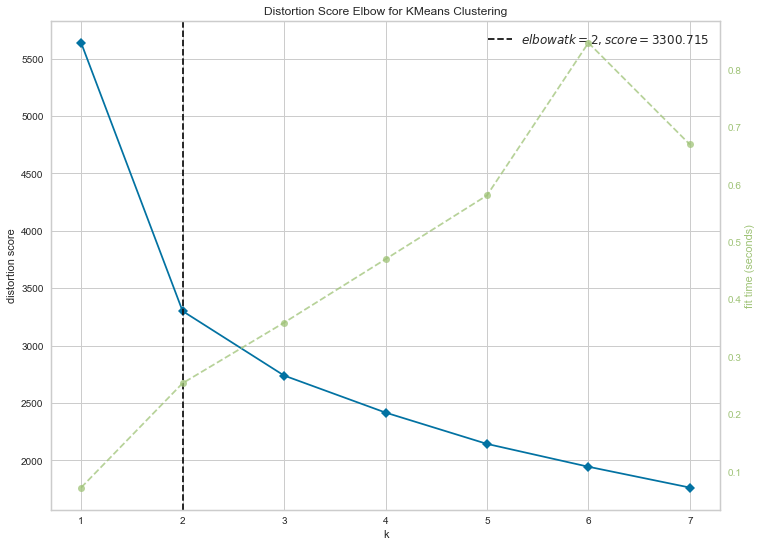

<Figure size 864x648 with 0 Axes>

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001D5D7600908>,
                     colors='yellowbrick', is_fitted='auto', model=None)

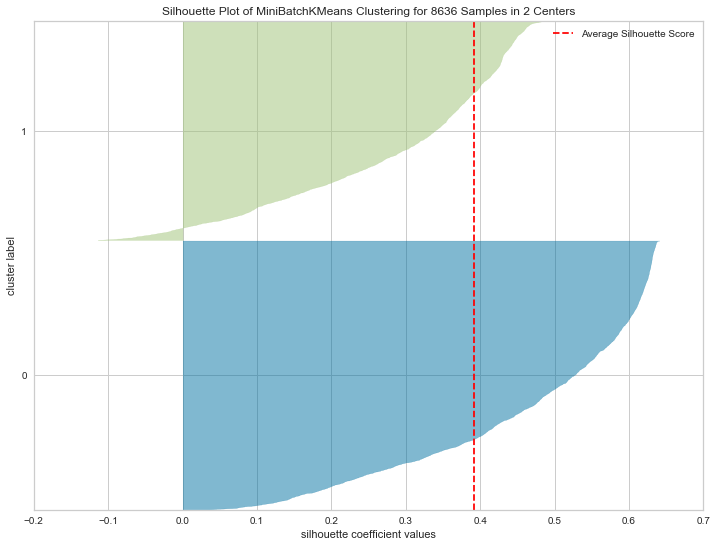

<Figure size 864x648 with 0 Axes>

InterclusterDistance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001D5D75B2D30>,
                     embedding='mds', is_fitted='auto', legend=True,
                     legend_loc='lower left', legend_size=1.5, max_size=25000,
                     min_size=10000, model=None, random_state=None,
                     scoring='membership')

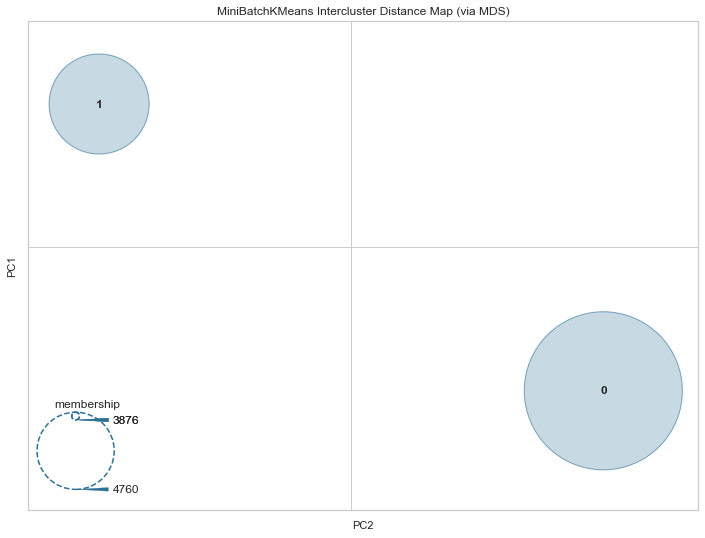

array([0, 0, 1, ..., 1, 0, 0])

array([[0.09160653, 0.85168285, 0.00717634, 0.00708558, 0.00281467,
        0.02833057, 0.17397936, 0.10441802, 0.06895806, 0.12097745,
        0.0345307 , 0.00933894, 0.13796738, 0.03040387, 0.01084225,
        0.07530446, 0.90853161],
       [0.07460268, 0.94516709, 0.03634774, 0.02282304, 0.03788697,
        0.0115221 , 0.89633053, 0.32844513, 0.75149695, 0.04870469,
        0.01445323, 0.08149967, 0.16382656, 0.04072341, 0.01188096,
        0.25243434, 0.94117382]])

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,0.091607,0.851683,0.007176,0.007086,0.002815,0.028331,0.173979,0.104418,0.068958,0.120977,0.034531,0.009339,0.137967,0.030404,0.010842,0.075304,0.908532
1,0.074603,0.945167,0.036348,0.022823,0.037887,0.011522,0.896331,0.328445,0.751497,0.048705,0.014453,0.081500,0.163827,0.040723,0.011881,0.252434,0.941174


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,1744.475850,0.851683,351.924799,288.817051,63.330171,1335.424310,0.173979,0.104418,0.068958,0.181466,4.247276,3.343340,4182.122897,1542.177512,828.433851,0.075304,11.451190
1,1420.669189,0.945167,1782.477678,930.295666,852.456862,543.119898,0.896331,0.328445,0.751497,0.073057,1.777748,29.176884,4956.605346,2065.599275,907.797881,0.252434,11.647043


EXPLANATION:

I chose 2 clusters because the elbow test indicated that number. 2 clusters are enough to interpret this data
17 variables and the Buiness Confidence Indicator are present.
The first cluster (cluster 0) consists of the credit card holders that spend big and use their CC very frequently
The second cluster (cluster 1) consists of the credit card holders that spend less and use their CC less frequently
We can use this dataset in order to segment people that are more likely to buy and target them with advertisments  
based on the fields they spent the most in!


In [18]:
# b) Same for the credit card dataset.

CCData=pd.read_csv("CCData.csv")
CCData.dropna(inplace=True)
CCData.info()
CCData.head()

X=CCData.iloc[:,1:]
min_max_scaler = preprocessing.MinMaxScaler()  # by default between 0 and 1

x_scaled_fit = min_max_scaler.fit(X)

x_scaled = min_max_scaler.fit_transform(X)
X_scaled = pd.DataFrame(x_scaled,columns=X.columns)
X_scaled.head()

plt.figure(figsize=(12,9))

# Now we apply KMeans
model = KMeans()

# we want first to find out how many clusters using the elbow technique
visualizer = KElbowVisualizer(model, k=(1,8))
visualizer.fit(X_scaled)       
visualizer.show()

plt.figure(figsize=(12,9))

# model = KMeans(3)
# model=MiniBatchKMeans(n_clusters=3, verbose=True).fit(X_scaled)

model=MiniBatchKMeans(n_clusters=2).fit(X_scaled)


visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_scaled)      
visualizer.show()

# Inter cluster distance 

plt.figure(figsize=(12,9))

#model=MiniBatchKMeans(n_clusters=3).fit(X_scaled)

visualizer = InterclusterDistance(model, min_size=10000)
#visualizer = InterclusterDistance(model)
visualizer.fit(X_scaled)
visualizer.show()


# Centroids
#center of a cluster!! chi bel credit card l bi koun bel nos!!
                         #hayde it's the thing we use most!!
model.labels_
model.cluster_centers_

pd.DataFrame(model.cluster_centers_, columns=X.columns)

# BECAUSE WE SCALED WE HAVE TO BRING IT BACK TO THE ORIGINAL RANGES

pd.DataFrame(x_scaled_fit.inverse_transform(model.cluster_centers_),columns=X.columns)

# --- Now with these values we can have an interpretation of what each cluster means ---
print("EXPLANATION:")
print()
    
print("I chose 2 clusters because the elbow test indicated that number. 2 clusters are enough to interpret this data") 
print("17 variables and the Buiness Confidence Indicator are present.")      
print("The first cluster (cluster 0) consists of the credit card holders that spend big and use their CC very frequently")
print("The second cluster (cluster 1) consists of the credit card holders that spend less and use their CC less frequently") 
print("We can use this dataset in order to segment people that are more likely to buy and target them with advertisments  ")
print("based on the fields they spent the most in!")